## Libraries

In [13]:
import numpy as np
from numpy import load
import time
import sys
import scipy
from scipy import interpolate
from scipy.integrate import odeint
from scipy.interpolate import RegularGridInterpolator
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
import dsharp_opac as opacity
import warnings
warnings.filterwarnings("ignore")

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng   #para intentar labels en LaTex:    usetex=True

## Constants

In [14]:
#!/usr/bin/env python

clight = 3.e10    #cm/s
kB = 1.38e-16     #erg/K
Ggrav = 6.672e-8  #cm**3/g/s**2
hP = 6.626e-27    #erg s
mH = 1.67e-24     #g
sigmaB = 5.67e-5  #erg/cm**2/K**4/s
year = 3.154e7    #seconds
AU = 1.496e13     #cm
pc = 3.086e18     #cm
Jy = 1.e-23       #erg/cm**2
Msun = 1.9891e33  #g
Rsun = 6.96e10    #cm
Lsun = 3.826e33   #erg/s
Tsun = 5780.      #K
Mearth = 5.972e27 #g
arcsec2rad = 4.84814136835e-6  #from arcsec to rad


With this cell we can see the arrays inside de .npz file. There is only NumPy arrays, no .pdf or other formats

In [15]:
data = load('default_opacities_smooth.npz')
lst = data.files
for item in lst:
    print(item)
    #print(data[item])

a
lam
k_abs
k_sca
g
rho_s


## Parameters

In [16]:
"""Disk"""
length = 250.                    #AU (size of the cube); length > 2*Rout
Rin = 5.00                       #AU (inner radius of the disk)
Rout = 120.                      #AU (outer radius of the disk)
Rc = 60.                         #AU (transition radius of the disk)
inc = 89.                        #deg (disk inclination between 0 and 90 degrees)
distance = 120.                  #pc  (disk distance)

"""Star"""                            
# This is only important if the temperature is computed by the model
Tstar = 4500.                    #K (Star effective temperature)
Mdot = 1.e-7                     #Solar masses / year
Mstar = 1.                       #Solar masses
Rstar = 6.96e11                  #cm
phi_angle = 0.05                 #rad

"""Convolution"""
beam = 0.1                       #arcsec

"""Radiative transfer"""
# Options: wl = {0.087, 0.13, 0.3, 0.7}
wl = 0.13                        #cm (Observed wavelenght). t should exist. 


"""What to do"""
wr_files = False                 #Write fits files
add_Star = False                 #Add star to the images? Problem with intensity scale
add_back = True                  #Add the 2.7 background intensity?
scattering = True                #Scattering ON or OFF?
plot_opacity = True
plot_sky = True                  #MAP (pdf)
plot_Temperature = True          #MAP of the temperature structure
intensity_log = True             #color map (intensity) in log scale?
opacity_log = True               #color map (opacity) in log scale?


"""Extra parameters"""
# Don´t change
nu = clight/wl                    #from wl to nu
inc = inc*np.pi/180.              #from deg to rad
Mdot = Mdot/year*Msun             #from solar masses/year to gram/sec
Mstar = Mstar*Msun                #from solar masses to gram


# I (javier) added this parameters, but are in the "main"
nx = 2**7+1 #+1 para tener un centro
ny = 2**7+1
Bright = np.zeros((ny,nx))
op_depth = np.zeros((ny,nx))
norm = 2.*hP*nu**3/clight**2


## Equations

In [17]:
#!/usr/bin/env python

def EQ_Height(r):
    if (r > Rin):
        return 0.1*r**(1.0) #In AU units
    else:
        return 0.1*(Rin)**(1.0) #In AU units


def EQ_density(x_d,y_d,z_d): #Dust density
    r = np.sqrt(x_d**2+y_d**2)
    H = EQ_Height(r)    
    if (r < Rin or r > Rout or abs(z_d) > 2.5*H):
        # at z=2H the diskmass is 95.45%
        return 0.
    else:
        Sigma = 1.*r**(-1.)*np.exp(-r/Rc)
        return Sigma*np.exp(-0.5*(z_d/H)**2)/np.sqrt(2.*np.pi)/H  # AU is not included due to integration is in terms of H

def f_modelo_gaussianas(radio, A, sigma):
    """
    Modelo de las emisiones que consiste en dos gaussianas de mismo ancho
    (mismo sigma)

    Input:
    ============
    params : [tuple] tupla con los parámetros de la amplitud y centro de las
    dos gaussianas, y el sigma que es el mismo para ambas
    x : [float] valor a evaluar
    ============

    Output:
    ============
    [float] valor de la curva en el punto x
    ============
    """
    #A1, mu1, sigma = 0.7, 50, 2
    mu1 = 50
    evaluacion = A * np.exp(-(radio-mu1)**2/sigma**2) + 0.1
    return evaluacion


def EQ_temperature(x_d,y_d,z_d):
    return funcion_T([z_d,y_d,x_d])
    #r = np.sqrt(x_d**2+y_d**2)
    #H = EQ_Height(r)
    #Temp = 10. (r/1.)**(-0.5)


def EQ_amax(x, y, z):
    radius = np.sqrt(x**2 + y**2)
    grain_size = f_modelo_gaussianas(radius, 0.7, 2)-\
                 (f_modelo_gaussianas(radius, 0.3, 5)-0.2)
    return grain_size  # In cm units



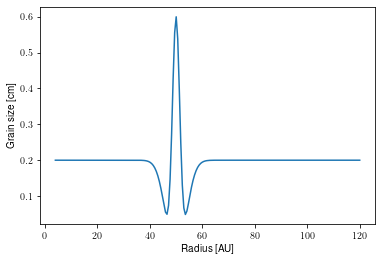

In [7]:
x_prueba = np.linspace(4, 120, 200)
plt.figure()
plt.plot(x_prueba, f_modelo_gaussianas(x_prueba, 0.7, 2)-
         (f_modelo_gaussianas(x_prueba, 0.3, 5)-0.2))
plt.xlabel('Radius [AU]')
plt.ylabel('Grain size [cm]')
plt.show()

In [8]:
np.min(f_modelo_gaussianas(x_prueba, 0.7, 2)-
         (f_modelo_gaussianas(x_prueba, 0.3, 5)-0.2))

0.04876720459159409

In [18]:
#!/usr/bin/env python

#--------------------------------------------------------------------------------

def FUN_rotation(x, y, z):
    """
    Changes the sky coordinates (x,y,z) to the disk coordinates (x_d,y_d,z_d).
    The x axis is the rotation axis.
    """
    x_d = x    
    y_d = y*np.cos(inc) - z*np.sin(inc)
    z_d = y*np.sin(inc) + z*np.cos(inc)
    return x_d,y_d,z_d


def FUN_intensity(I, z, x, y, optde):
    """
    Radiative transfer equation
    """
    x_d,y_d,z_d = FUN_rotation(x,y,z)
    density = EQ_density(x_d,y_d,z_d)
    amax = EQ_amax(x_d,y_d,z_d)
    opa = function_ext(amax)
    S = funcion_S([z_d,y_d,x_d])
    # z es la variable de integracion (debe ser evaluada en cualquier punto)
    dIdz = -S*opa*density*np.exp(-optde(z))
    return dIdz


def FUN_tau(tt, z, x, y):  # Creo que no se usa tt
    """
    Optical depth
    """
    x_d, y_d, z_d = FUN_rotation(x, y, z)
    density = EQ_density(x_d, y_d, z_d)
    amax = EQ_amax(x_d, y_d, z_d)
    opa = function_ext(amax)
    dtau = -opa*density
    return dtau


def FUN_tau_zaxis(tt, z, x, y):
    x_d, y_d, z_d = x, y, z
    density = EQ_density(x_d, y_d, z_d)
    amax = EQ_amax(x_d, y_d, z_d)
    opa = function_ext(amax)
    dtau = -opa*density
    return dtau


def FUN_BB(nu,T):
    """
    Black body radiation
    """
    B = 1./(np.exp(hP*nu/kB/T) - 1.)
    return B


def FUN_limits_mult(xx, yy):
    """
    *Function description*

    Input:
    ============
    xx : [float] x sky coordinate
    yy : [float] y sky coordinate
    ============

    Output:
    ============
    z_crit : [list]
    ============
    """
    Hout = EQ_Height(Rout)
    # Based on the geometry of the disk
    lim_z = Rout*np.sin(inc) + 2.*Hout*np.cos(inc)
    # Based on the geometry of the disk
    lim_y = Rout*np.cos(inc) + 2.*Hout*np.sin(inc)
    z_arr = np.linspace(1.1*lim_z, -1.1*lim_z, 200)
    z_crit = []  # & This list could be a numpy array

    if ((np.abs(xx) <= Rout) and (np.abs(yy) <= lim_y)):
        # & And an else?
        xd, yd, zd = FUN_rotation(xx, yy, z_arr)
        crit = np.zeros((len(z_arr)))
        density = np.zeros((len(z_arr)))
        for ii in range(len(z_arr)):
            # Crea un vector de densidad en la linea de vision
            if (EQ_density(xd,yd[ii],zd[ii]) == 0.):
                crit[ii] = 0
            else:
                crit[ii] = 1
    
        for ii in range(len(z_arr)):
            # Ve los indices donde cambia de 0 a algun valor, o de algun valor a 0(fronteras)
            if ((ii != 0) and (crit[ii] - crit[ii-1] != 0 )):
                z_crit.append(z_arr[ii])
            elif(ii == 0 and crit[0] == 1):
                z_crit.append(z_arr[0])              
                
    return z_crit


def FUN_creates_source_function(x_array,y_array):
    """
    *Function description*

    Input:
    ============
    x_array : [list or ndarray] ...
    y_array : [list or ndarray] ...
    ============

    Output:
    ============
    funcion_S : [] Source function (3D)
    funcion_T : [] Temperature function (3D)
    ============
    """
    # Arrays and limits
    Hout = EQ_Height(Rout)
    z_array = np.linspace(-2.*Hout, 2.*Hout, 200)
    Sfunction = np.zeros((len(z_array), len(y_array), len(x_array)))
    Temfunction = np.zeros((len(z_array), len(y_array), len(x_array)))    
    op_depth_p = np.zeros((len(y_array), len(x_array)))

    # Computes the optical depth (perpendicular to the disk midplane)
    for j in range(len(y_array)):
        for i in range(len(x_array)):
            if (x_array[i] == 0. and y_array[j] == 0.):
                Sfunction[:, j, i] = 0.
                Temfunction[:, j, i] = 0.
            else:
                rad = np.sqrt(x_array[i]**2 + y_array[j]**2)
                Hscale = EQ_Height(rad)

                z_integ = np.linspace(2.*Hscale,-2.*Hscale,200)           
                sol = odeint(FUN_tau_zaxis, 0. ,z_integ,
                             args=(x_array[i],y_array[j])).T[0]
                op_depth_p[j][i] = sol[len(z_integ)-1]

                inter_opt = interpolate.interp1d(z_integ, sol,
                                                 kind='linear', 
                                                 bounds_error=False,
                                                 fill_value=0.)
                for k in range(len(z_array)):
                    amax = EQ_amax(x_array[i], y_array[j], z_array[k])
                    albedo = function_alb(amax)
                    # Temperature
                    Omega2 = Ggrav*Mstar/(rad*AU)**3
                    Teff4 = 3.*Mdot*Omega2/8./np.pi/sigmaB
                    Tacc4 = 3./4.*(7.*inter_opt(abs(z_array[k])) + 2./3.)*Teff4
                    Tirr4 = Tstar**4./4.*(Rstar/rad/AU)**2*np.exp(-7.*inter_opt(abs(z_array[k]))/phi_angle)
                    Temfunction[k, j, i] = (Tacc4 + Tirr4)**(0.25)
                    Sfunction[k, j, i] = FUN_BB(nu,
                                                Temfunction[k, j, i])*(1.+ albedo*FUN_f(inter_opt(z_array[k]),
                                                op_depth_p[j][i], albedo))

    # Create the source function and temperature in 3D
    funcion_S = RegularGridInterpolator((z_array, y_array, x_array), Sfunction,bounds_error=False, fill_value=None)
    funcion_T = RegularGridInterpolator((z_array, y_array, x_array), Temfunction,bounds_error=False,fill_value=None)
    return funcion_S, funcion_T


def FUN_f(t,tau,alb):
    eps = np.sqrt(1.-alb)
    fff = np.exp(-np.sqrt(3.)*eps*t) + np.exp(np.sqrt(3.)*eps*(t-tau))
    fff = fff/( np.exp(-np.sqrt(3.)*eps*tau)*(eps-1.) - (eps+1.) )
    return fff


with np.load('default_opacities_smooth.npz') as d:
    """
    Read the opacity tables DSHARP (load opacities)
    """
    a_w     = d['a']
    gsca_w  = d['g']
    lam_w   = d['lam']
    k_abs_w = d['k_abs']
    k_sca_w = d['k_sca']

lam_avgs = wl
# We split the opacities within the range of frequency to make the calculations faster
k_abs_w = k_abs_w[(0.9*lam_avgs<lam_w) & (1.1*lam_avgs>lam_w),:]
k_sca_w = k_sca_w[(0.9*lam_avgs<lam_w) & (1.1*lam_avgs>lam_w),:]
k_sca_w = k_sca_w*(1. -  gsca_w[(0.9*lam_avgs<lam_w) & (1.1*lam_avgs>lam_w),:])
lam_w = lam_w[(0.9*lam_avgs<lam_w) & (1.1*lam_avgs>lam_w)]

opac_grid = opacity.size_average_opacity(lam_avgs, a_w, lam_w, k_abs_w.T, k_sca_w.T, q=3.5, plot=True)


function_ext = interpolate.interp1d(a_w, opac_grid['ka'][:] + opac_grid['ks'][:],kind='cubic')
function_alb = interpolate.interp1d(a_w, opac_grid['ks'][:]/(opac_grid['ka'][:]+opac_grid['ks'][:]),kind='cubic')
if not scattering:
    function_alb = interpolate.interp1d(a_w, np.zeros((np.shape(opac_grid['ks'][:]))),kind='cubic')


FileNotFoundError: missing font metrics file: phvr7t

## Convolution

In [11]:
std = beam*distance                       #from arcsec to au
print ('The beam convolution is =', std, 'au')
std = std/2./np.sqrt(2.*np.log(2.))       #from FWHM (beam) to standard deviation
std = std*nx/length                       #beam in pixels

kernel = Gaussian2DKernel(std)

conv_Bright = convolve(Bright,kernel)
conv_TB = hP*nu/kB/np.log(norm/conv_Bright/Jy + 1.)


#The flux should be the same ( ... the sum is approx the same ...)
#conv_Bright = conv_Bright/np.sum(conv_Bright)*np.sum(Bright)
#conv_TB = conv_TB/np.sum(conv_TB)*np.sum(TB)


The beam convolution is = 12.0 au


# NO CORRER

In [12]:
#PLOTS

##################################################

#if(plot_opacity == True):
#    p_plot = np.linspace(2.0,6.0,21)
#    a_plot = np.logspace(np.log10(0.001),np.log10(10.),21)
#
#    EXT_plot = EXT(a_plot,p_plot)
#    ALB_plot = ALB(a_plot,p_plot)
#    
#    plt.close()
#    fig = plt.figure()
#    ax = fig.add_subplot(111)
#    im = ax.imshow(EXT_plot, cmap='hot', origin='lower', interpolation='gaussian',aspect='auto')
#    cbar = fig.colorbar(im,orientation='vertical')
#    cbar.set_label(r"$\chi_{"+str(wl)+"\mathrm{cm}} [\mathrm{cm}^2/\mathrm{g}_{\mathrm{dust}}]$")
#    plt.xticks( np.linspace(0,len(a_plot)-1,len(a_plot)) , np.round_(np.log10(a_plot),decimals=2))
#    plt.yticks( np.linspace(0,(len(p_plot)-1),len(p_plot)), np.round_(p_plot, decimals=2))
#    plt.xticks(rotation=90)
#    plt.yticks(rotation=0)
#    plt.xlabel('$\log (a_{\mathrm{max}} [\mathrm{cm}])$')
#    plt.ylabel('$p$')
#    plt.savefig('Opacity/EXT_nu'+str(np.round(nu/1.e9,2))+'GHz.pdf', bbox_inches='tight')
#    print ('   - Opacity/EXT_nu'+str(np.round(nu/1.e9,2))+'GHz.pdf saved!')
#
#    plt.close()
#    fig = plt.figure()
#    ax = fig.add_subplot(111)
#    im = ax.imshow(ALB_plot, cmap='hot', origin='lower', interpolation='gaussian',aspect='auto')
#    cbar = fig.colorbar(im,orientation='vertical')
#    cbar.set_label(r"$\omega_{"+str(wl)+"\mathrm{cm}}$")
#    plt.xticks( np.linspace(0,len(a_plot)-1,len(a_plot)) , np.round_(np.log10(a_plot),decimals=2))
#    plt.yticks( np.linspace(0,(len(p_plot)-1),len(p_plot)), np.round_(p_plot, decimals=2))
#    plt.xticks(rotation=90)
#    plt.yticks(rotation=0)
#    plt.xlabel('$\log (a_{\mathrm{max}} [\mathrm{cm}])$')
#    plt.ylabel('$p$')
#    plt.savefig('Opacity/ALB_nu'+str(np.round(nu/1.e9,2))+'GHz.pdf', bbox_inches='tight')
#    print ('   - Opacity/ALB_nu'+str(np.round(nu/1.e9,2))+'GHz.pdf saved!')

##########################################################    
if(plot_sky == True):
    plt.close()
    fig , ax = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
    fig.subplots_adjust(hspace=.15, wspace=.1)
    plt.suptitle('$\lambda = %.2f \ \mathrm{cm}; \ i = %.1f \ \mathrm{deg}$'%(wl,inc*180./np.pi))
    ##########################################################    
    if(intensity_log == True):
        im = ax[0][0].imshow(np.log10(Bright*1.e3), cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][0])
        cbar.set_label(r'$\log (I_{\nu})\ \mathrm{[mJy/pix]}$')

        im = ax[0][1].imshow(np.log10(conv_Bright*1.e3), cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][1])
        cbar.set_label(r'$\log (I_{\nu})\ \mathrm{[mJy/beam]}$')
        beam_d = patches.Circle((-0.75*length/2.,-0.75*length/2),radius=beam*distance/2.,facecolor='w', edgecolor='k')
        ax[0][1].add_patch(beam_d)
        
    else:
        im = ax[0][0].imshow(Bright*1.e3, cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')        
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][0])
        cbar.set_label(r'$I_{\nu} \ \mathrm{[mJy/pix]}$')

        im = ax[0][1].imshow(conv_Bright*1.e3, cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')        
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][1])
        cbar.set_label(r'$I_{\nu} \ \mathrm{[mJy/beam]}$')
        beam_d = patches.Circle((-0.75*length/2.,-0.75*length/2),radius=beam*distance/2.,facecolor='w', edgecolor='k')
        ax[0][1].add_patch(beam_d)


    ax[0][0].set_ylabel(r'$y \ \mathrm{[au]}$')
    ax[0][0].set_title(r'$\mathrm{Intensity \ Model}$')
    ax[0][0].set_xticks([])   
    ax[0][1].set_yticks([])
    ax[0][1].set_xticks([])            
    ax[0][1].set_title(r'$\mathrm{Convolved \ intensity}$')

    
    ##########################################################
    if(np.nanmax(op_depth) > 1.):
        Contorno = True
    else:
        Contorno = False
    
    if(opacity_log == True):
        im = ax[1][0].imshow(np.log10(op_depth), cmap='hot_r', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[1][0])
        
        if(Contorno == True):
            con = ax[1][0].contour(np.log10(op_depth), levels=[0.0],colors='k',linestyles='dashed',origin='lower', aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)])
            ax[1][0].plot([],[],'k--',label=r'$\tau_{\chi_{\nu}} = 1$')

    else:
        im = ax[1][0].imshow(op_depth, cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[1][0])
        if(Contorno == True):
            con = ax[1][0].contour(op_depth, levels=[1.0],colors='k',linestyles='dashed',origin='lower', aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)])
            
    if (scattering == True):
        cbar.set_label(r'$\log (\tau_{\chi_{\nu}})$')
    else:
        cbar.set_label(r'$\log (\tau_{\kappa_{\nu}})$')


    im = ax[1][1].imshow(conv_TB, cmap='hot', origin='lower',aspect='auto',
                         extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
#    ax[1][1].add_patch(beam_d)
    cbar = fig.colorbar(im,orientation='vertical',ax=ax[1][1])
    cbar.set_label(r'$T_{\mathrm{B}} [\mathrm{K/beam}]$')

        
    ax[1][0].legend(loc=3,framealpha=0.2,fontsize=12)
    ax[1][0].set_ylabel(r'')
    ax[1][1].set_yticks([])   
    ax[1][0].set_title(r'$\mathrm{Optical \ depth \ model}$')

    for j in range(2):                
        ax[1][j].set_xlabel(r'$x \ \mathrm{[au]}$')
    
    plt.savefig('Results/img/Diks_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.pdf', bbox_inches='tight')
    print ('   - Results/img/Diks_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.pdf saved!')


##########################################################    
if(plot_Temperature == True):
    plt.close()
    fig , ax = plt.subplots(nrows=1,ncols=1,figsize=(14,6))
    im = ax.imshow(np.log10(map_T),cmap='hot', origin='lower',aspect='auto',
                       extent=[x_array[0],x_array[nx-1],z_temp[0],z_temp[len(z_temp)-1]],interpolation='None')
    ax.contour(np.log10(map_T), 4,colors='w',linestyles='dashed',origin='lower', aspect='auto',
                       extent=[x_array[0],x_array[nx-1],z_temp[0],z_temp[len(z_temp)-1]])
    cbar = fig.colorbar(im,orientation='vertical',ax=ax)
    cbar.set_label(r'$\log (T_{\mathrm{d}} [\mathrm{K}])$')
    ax.set_xlim(xmin=0.,xmax=Rout)
    ax.set_xlabel(r'$\varpi \ \mathrm{[au]}$',fontsize=16)
    ax.set_ylabel(r'$z \ \mathrm{[au]}$',fontsize=16)    
    plt.savefig('Results/img/TemperatureStructure_Mdot'+str(Mdot*year/Msun)+'_Tstar'+str(Tstar)+'.pdf', bbox_inches='tight')
    print ('   - Results/img/TemperatureStructure_Mdot'+str(Mdot*year/Msun)+'_Tstar'+str(Tstar)+'.pdf')


NameError: name 'x_array' is not defined

In [14]:
from astropy.io import fits

fits.writeto('Results/fits/Intensity_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits',
             Bright,overwrite=True)
print ('   - Results/fits/Intensity_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits saved!')

fits.writeto('Results/fits/OpticalD_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits',
             op_depth,overwrite=True)
print ('   - Results/fits/OpticalD_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits saved!')


   - Results/fits/Intensity_wl0.13_inc0.0deg.fits saved!
   - Results/fits/OpticalD_wl0.13_inc0.0deg.fits saved!


# Main

In [12]:
#!/usr/bin/env python
start_time = time.time()

print ('**********************************************************')
print ('The disk inclination is', inc*180./np.pi, 'degrees')
print ('The distance to the disk is', distance, 'pc')
print ('The wavelenght is', wl, 'cm, frequency = ', nu/1.e9, 'GHz')

# Sky plane
#nx = 2**7+1  # +1 para tener un centro
#ny = 2**7+1
nx = 2**7+1  # +1 para tener un centro
ny = 2**7+1
x_array = np.zeros((nx))
y_array = np.zeros((ny))

for i in range(nx):
    # Llena la matriz con valores fisicos
    x_array[i] = length*(i/(nx-1.)-0.5)
for j in range(ny):
    y_array[j] = length*(j/(ny-1.)-0.5)

#Creates the 3D Source function
print ('- Creating 3D source function ...')
funcion_S, funcion_T = FUN_creates_source_function(x_array, y_array)

# 2D grid (sky plane)
Bright = np.zeros((ny,nx))
op_depth = np.zeros((ny,nx))
norm = 2.*hP*nu**3/clight**2
print ('- Creating image ...')

for i in range(nx):
    print (np.round(i*100./nx,2), '%')  # percent
    for j in range(ny):
        z_crit = FUN_limits_mult(x_array[i],y_array[j])
        if (len(z_crit) == 0): # i.e. No density in the line of sight
            if (add_back == True):
                Bright[j][i] = FUN_BB(nu, 2.7)*norm
            else:
                Bright[j][i] = np.nan
            op_depth[j][i] = np.nan
        else:
            Nhalf = int(len(z_crit)/2)
            
            # Creates arrays of Z at each range
            z_array = np.zeros((Nhalf, 100)) 
            for iz in range(Nhalf):
                z_array[iz] = np.linspace(z_crit[2*iz],z_crit[2*iz+1],100)
                
            #Saves the vector optdepth at each range
            sol = np.zeros((Nhalf,100)) 
            for iz in range(Nhalf):
                sol[iz] = odeint(FUN_tau,0.,z_array[iz],
                                 args=(x_array[i],y_array[j])).T[0]
                
            #Saves the total optdepth at each range
            opt = np.zeros((Nhalf))
            for iz in range(Nhalf):
                opt[iz] = sol[iz][len(z_array[iz])-1]
                
            #Saves the total optdepth in the line of sight
            op_depth[j][i] =  np.sum(opt)

            #Saves the optdepth functions (to be interpolated)
            optde = []                      
            for iz in range(Nhalf):
                optde.append(interpolate.interp1d(z_array[iz],sol[iz],kind='linear',fill_value='extrapolate')) #quitar extrapolate?
                
            #Saves the total intensity at each range
            sol_I = np.zeros((Nhalf,100)) 
            for iz in range(Nhalf):
                sol_I[iz] = odeint(FUN_intensity,0.,z_array[iz],
                                   args=(x_array[i],y_array[j],optde[iz])).T[0]*norm
                                
            #Sum all the intensities in the line of sight
            #It takes into account all the right-side optical depth regions
            for iz in range(Nhalf):
                f_ext = 1.
                for indice in range(0,iz):
                    f_ext = f_ext*np.exp(-opt[indice])
                Bright[j][i] = Bright[j][i] + sol_I[iz][len(z_array[iz])-1]*f_ext
                
            #Add the background radiation
            if (add_back == True):
                Bright[j][i] = Bright[j][i] + FUN_BB(nu,2.7)*np.exp(-op_depth[j][i])*norm

        ######################################################################################################
        #Agrega la estrella
        ######################################################################################################
        if((i == (nx-1)/2) and (j == (nx-1)/2) and (add_Star == True)):
            if(len(z_crit) == 0):
                opt_star = 0.
            else:
                if(len(z_crit) == 2): #No hay casos si se puede concatenar todo de alguna manera inteligente
                    opt_star = sol[0]
                    z_star = z_array[0]
                else: #En realidad ANTES de llegar a la estrella solo puede ser 2 o 4 (en un disco)
                    sol[1] = sol[1] + sol[0][len(sol[0])-1] #accumulated optical depth
                    opt_star = np.concatenate((sol[0],sol[1]))
                    z_star = np.concatenate((z_array[0],z_array[1]))
                z_star = z_star[np.where(z_star>=0.)] #The star is at z=0
                opt_star = opt_star[np.where(z_star>=0.)]
                opt_star = opt_star[len(opt_star)-1]
        ######################################################################################################
            B_star = FUN_BB(nu,Tstar)*np.exp(-opt_star)*norm    
            Bright[j][i] = Bright[j][i] + B_star
            print ('   - Star added to the image:')
            print ('     tau on the star = ', opt_star)
                
Area  = (x_array[1] - x_array[0])*(y_array[1] - y_array[0])*AU**2
Bright = Bright*Area/(distance*pc)**2/Jy

if (add_Star == True):
    B_star = B_star*Area/(distance*pc)**2/Jy
    print ('- The disk + star flux is = '+str(np.nansum(Bright)*1.e3)+' mJy')
    print ('- The star flux is = '+str(B_star*1.e3)+'mJy')
    print ('- The disk star flux is = '+str((np.nansum(Bright)-B_star)*1.e3)+' mJy')
else:
    print ('- The total disk flux is = '+str(np.nansum(Bright)*1.e3)+' mJy')



####################################################################################################
#From Jy/pix to Kelvin/pix
TB = hP*nu/kB/np.log(norm/Bright/Jy + 1.)

####################################################################################################
#Map of the temperature structure
z_temp = np.linspace(0.,EQ_Height(np.max(x_array)),100)
map_T = np.zeros((len(z_temp),len(x_array)))

for k in range(len(z_temp)):
    for i in range(len(x_array)):
        if (abs(x_array[i]) < Rin or abs(x_array[i]) > Rout or  z_temp[k] > 2.*EQ_Height(abs(x_array[i]))):
            map_T[k,i] = np.nan
        else:
            map_T[k,i] = EQ_temperature(x_array[i],0.,z_temp[k])


####################################################################################################
#Convolves
#exec(open('convolution.py').read())
            
####################################################################################################
print ('- Files written:')
if plot_sky == True:
    exec(open('plots.py').read())
#if wr_files == True:
#    exec(open('write_files.py').read())
####################################################################################################
final_time = time.time()
print ('- Total execution time =', (final_time - start_time)/60., 'minutes')
print ('**********************************************************')
####################################################################################################


**********************************************************
The disk inclination is 89.0 degrees
The distance to the disk is 120.0 pc
The wavelenght is 0.13 cm, frequency =  230.76923076923077 GHz
- Creating 3D source function ...
- Creating image ...
0.0 %
0.78 %
1.55 %
2.33 %
3.1 %
3.88 %
4.65 %
5.43 %
6.2 %
6.98 %
7.75 %
8.53 %
9.3 %
10.08 %
10.85 %
11.63 %
12.4 %
13.18 %
13.95 %
14.73 %
15.5 %
16.28 %
17.05 %
17.83 %
18.6 %
19.38 %
20.16 %
20.93 %
21.71 %
22.48 %
23.26 %
24.03 %
24.81 %
25.58 %
26.36 %
27.13 %
27.91 %
28.68 %
29.46 %
30.23 %
31.01 %
31.78 %
32.56 %
33.33 %
34.11 %
34.88 %
35.66 %
36.43 %
37.21 %
37.98 %
38.76 %
39.53 %
40.31 %
41.09 %
41.86 %
42.64 %
43.41 %
44.19 %
44.96 %
45.74 %
46.51 %
47.29 %
48.06 %
48.84 %
49.61 %
50.39 %
51.16 %
51.94 %
52.71 %
53.49 %
54.26 %
55.04 %
55.81 %
56.59 %
57.36 %
58.14 %
58.91 %
59.69 %
60.47 %
61.24 %
62.02 %
62.79 %
63.57 %
64.34 %
65.12 %
65.89 %
66.67 %
67.44 %
68.22 %
68.99 %
69.77 %
70.54 %
71.32 %
72.09 %
72.87 %
73.64 %
7

FileNotFoundError: missing font metrics file: phvr7t

In [17]:
fits.writeto('Results/fits/Intensity_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits',
             Bright,overwrite=True)
print ('   - Results/fits/Intensity_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits saved!')

fits.writeto('Results/fits/OpticalD_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits',
             op_depth,overwrite=True)
print ('   - Results/fits/OpticalD_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg.fits saved!')

   - Results/fits/Intensity_wl0.13_inc0.0deg.fits saved!
   - Results/fits/OpticalD_wl0.13_inc0.0deg.fits saved!


In [9]:
std = beam*distance                       #from arcsec to au
print ('The beam convolution is =', std, 'au')
std = std/2./np.sqrt(2.*np.log(2.))       #from FWHM (beam) to standard deviation
std = std*nx/length                       #beam in pixels

kernel = Gaussian2DKernel(std)

conv_Bright = convolve(Bright,kernel)
conv_TB = hP*nu/kB/np.log(norm/conv_Bright/Jy + 1.)

The beam convolution is = 12.0 au


   - Results/img/Diks_wl0.13_inc89.0deg-gaussian.pdf saved!
   - Results/img/TemperatureStructure_Mdot1e-07_Tstar4500.0-gaussian.pdf


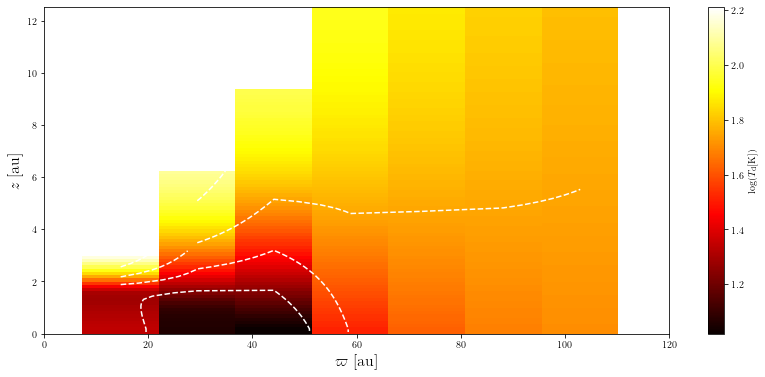

In [10]:
if(plot_sky == True):
    
    plt.close()
    fig , ax = plt.subplots(nrows=2,ncols=2,figsize=(15,12))
    fig.subplots_adjust(hspace=.15,wspace=.1)
    plt.suptitle('$\lambda = %.2f \ \mathrm{cm}; \ i = %.1f \ \mathrm{deg}$'%(wl,inc*180./np.pi))
    ##########################################################    
    if(intensity_log == True):
        im = ax[0][0].imshow(np.log10(Bright*1.e3), cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][0])
        cbar.set_label(r'$\log (I_{\nu})\ \mathrm{[mJy/pix]}$')

        im = ax[0][1].imshow(np.log10(conv_Bright*1.e3), cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][1])
        cbar.set_label(r'$\log (I_{\nu})\ \mathrm{[mJy/beam]}$')
        beam_d = patches.Circle((-0.75*length/2.,-0.75*length/2),radius=beam*distance/2.,facecolor='w', edgecolor='k')
        ax[0][1].add_patch(beam_d)
        
    else:
        im = ax[0][0].imshow(Bright*1.e3, cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')        
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][0])
        cbar.set_label(r'$I_{\nu} \ \mathrm{[mJy/pix]}$')

        im = ax[0][1].imshow(conv_Bright*1.e3, cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')        
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[0][1])
        cbar.set_label(r'$I_{\nu} \ \mathrm{[mJy/beam]}$')
        beam_d = patches.Circle((-0.75*length/2.,-0.75*length/2),radius=beam*distance/2.,facecolor='w', edgecolor='k')
        ax[0][1].add_patch(beam_d)


    ax[0][0].set_ylabel(r'$y \ \mathrm{[au]}$')
    ax[0][0].set_title(r'$\mathrm{Intensity \ Model}$')
    ax[0][0].set_xticks([])   
    ax[0][1].set_yticks([])
    ax[0][1].set_xticks([])            
    ax[0][1].set_title(r'$\mathrm{Convolved \ intensity}$')

    
    ##########################################################
    if(np.nanmax(op_depth) > 1.):
        Contorno = True
    else:
        Contorno = False
    
    if(opacity_log == True):
        im = ax[1][0].imshow(np.log10(op_depth), cmap='hot_r', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[1][0])
        
        if(Contorno == True):
            con = ax[1][0].contour(np.log10(op_depth), levels=[0.0],colors='k',linestyles='dashed',origin='lower', aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)])
            ax[1][0].plot([],[],'k--',label=r'$\tau_{\chi_{\nu}} = 1$')

    else:
        im = ax[1][0].imshow(op_depth, cmap='hot', origin='lower',aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
        cbar = fig.colorbar(im,orientation='vertical',ax=ax[1][0])
        if(Contorno == True):
            con = ax[1][0].contour(op_depth, levels=[1.0],colors='k',linestyles='dashed',origin='lower', aspect='auto',
                       extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)])
            
    if (scattering == True):
        cbar.set_label(r'$\log (\tau_{\chi_{\nu}})$')
    else:
        cbar.set_label(r'$\log (\tau_{\kappa_{\nu}})$')


    im = ax[1][1].imshow(conv_TB, cmap='hot', origin='lower',aspect='auto',
                         extent=[np.min(x_array),np.max(x_array),np.min(y_array),np.max(y_array)],interpolation='None')
#    ax[1][1].add_patch(beam_d)
    cbar = fig.colorbar(im,orientation='vertical',ax=ax[1][1])
    cbar.set_label(r'$T_{\mathrm{B}} [\mathrm{K/beam}]$')

        
    ax[1][0].legend(loc=3,framealpha=0.2,fontsize=12)
    ax[1][0].set_ylabel(r'')
    ax[1][1].set_yticks([])   
    ax[1][0].set_title(r'$\mathrm{Optical \ depth \ model}$')

    for j in range(2):                
        ax[1][j].set_xlabel(r'$x \ \mathrm{[au]}$')
    
    plt.savefig('Results/img/Diks_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg-gaussian.pdf', bbox_inches='tight')
    print ('   - Results/img/Diks_wl'+str(np.round(wl,2))+'_inc'+str(np.round(inc*180./np.pi,2))+'deg-gaussian.pdf saved!')


##########################################################    
if(plot_Temperature == True):
    plt.close()
    fig , ax = plt.subplots(nrows=1,ncols=1,figsize=(14,6))
    im = ax.imshow(np.log10(map_T),cmap='hot', origin='lower',aspect='auto',
                       extent=[x_array[0],x_array[nx-1],z_temp[0],z_temp[len(z_temp)-1]],interpolation='None')
    ax.contour(np.log10(map_T), 4,colors='w',linestyles='dashed',origin='lower', aspect='auto',
                       extent=[x_array[0],x_array[nx-1],z_temp[0],z_temp[len(z_temp)-1]])
    cbar = fig.colorbar(im,orientation='vertical',ax=ax)
    cbar.set_label(r'$\log (T_{\mathrm{d}} [\mathrm{K}])$')
    ax.set_xlim(xmin=0.,xmax=Rout)
    ax.set_xlabel(r'$\varpi \ \mathrm{[au]}$',fontsize=16)
    ax.set_ylabel(r'$z \ \mathrm{[au]}$',fontsize=16)    
    plt.savefig('Results/img/TemperatureStructure_Mdot'+str(Mdot*year/Msun)+'_Tstar'+str(Tstar)+'-gaussian.pdf', bbox_inches='tight')
    print ('   - Results/img/TemperatureStructure_Mdot'+str(Mdot*year/Msun)+'_Tstar'+str(Tstar)+'-gaussian.pdf')
